# Experiments


In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

from experiment_track import CDRGenerate, Metrics
from data import DataCollator, PairedBinder
from torch.utils.data import DataLoader
from model import Transformer
from params import GetParams
from typing import Dict
import numpy as np
import os
from transformers import BertTokenizer, BertModel
import time
from tqdm import tqdm

import pickle
def model_loader(ckpt, model_params: Dict):
    return Transformer().load_from_checkpoint(ckpt, **model_params)

plt.rcParams['font.sans-serif'] = ['Arial Rounded MT Bold']


In [3]:
collator_fn = DataCollator()
params = GetParams("./setting.yaml").model_params()
current_model = model_loader("./experiment_outs/epoch=969-step=93120.ckpt", params)

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False,
                                            cache_dir='../absolute_antibody/cache_model')
pretrained_model = BertModel.from_pretrained("Rostlab/prot_bert",
                                                cache_dir='../absolute_antibody/cache_model')



Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# 1. perplexity of 15 held-out antigen
a, b = [], []
per_seq = []
for i in os.listdir("../experiments_data/test_split"):
    data = PairedBinder('test', "../experiments_data/test_split/" + i)
    loader = next(iter(DataLoader(data, batch_size=10000000, collate_fn=collator_fn)))
    metrics = Metrics(model=current_model, loader=loader)
    mean_loss = metrics.perplexity()
    perp = np.exp(mean_loss)
    mean_perp = np.exp(np.mean(mean_loss))
    per_seq.append(perp)
    print(f"PDB: {i[:6]}, Max perp: {np.max(perp):4f}, Mean perp: {np.min(perp):4f}, Average perp: {np.mean(mean_perp):4f}")
    a.append(i[:6])
    b.append(np.mean(mean_perp))


PDB: 1OSP_O, Max perp: 43.463744, Mean perp: 1.443424, Average perp: 2.904506
PDB: 1S78_B, Max perp: 81.600543, Mean perp: 1.362430, Average perp: 2.910311
PDB: 1YJD_C, Max perp: 641.591970, Mean perp: 1.400163, Average perp: 3.364634
PDB: 1ZTX_E, Max perp: 14.601395, Mean perp: 1.395515, Average perp: 2.162618
PDB: 2R0K_A, Max perp: 708.831744, Mean perp: 1.370208, Average perp: 4.023154
PDB: 3TT1_A, Max perp: 441.564843, Mean perp: 1.401425, Average perp: 2.022603
PDB: 3U9P_C, Max perp: 201.529710, Mean perp: 1.427514, Average perp: 3.177654
PDB: 4I18_R, Max perp: 21.172691, Mean perp: 1.391744, Average perp: 2.305255
PDB: 4N9G_C, Max perp: 239.246119, Mean perp: 1.360082, Average perp: 2.460612
PDB: 4U6V_A, Max perp: 952.392574, Mean perp: 1.281286, Average perp: 2.462727
PDB: 5EII_G, Max perp: 69.009018, Mean perp: 1.454062, Average perp: 3.988778
PDB: 5H35_C, Max perp: 1275.045074, Mean perp: 1.452772, Average perp: 4.411660
PDB: 5HDQ_A, Max perp: 7.884764, Mean perp: 1.440850, Av

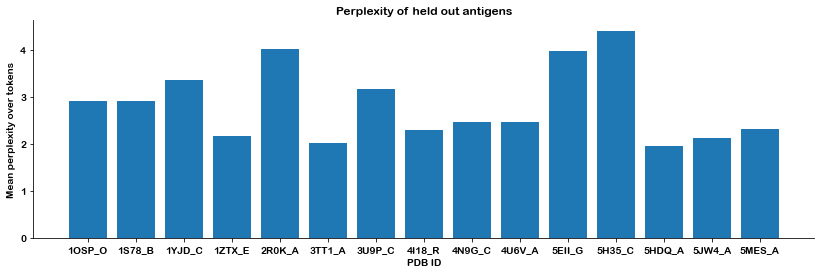

In [5]:
fig, ax = plt.subplots(figsize=(14,4))
ax.bar(a, b)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("Perplexity of held out antigens")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("PDB ID")
ax.set_ylabel("Mean perplexity over tokens")
fig.savefig("../experiments_data/figures/Perplexity of held out antigens.pdf", dpi=600)


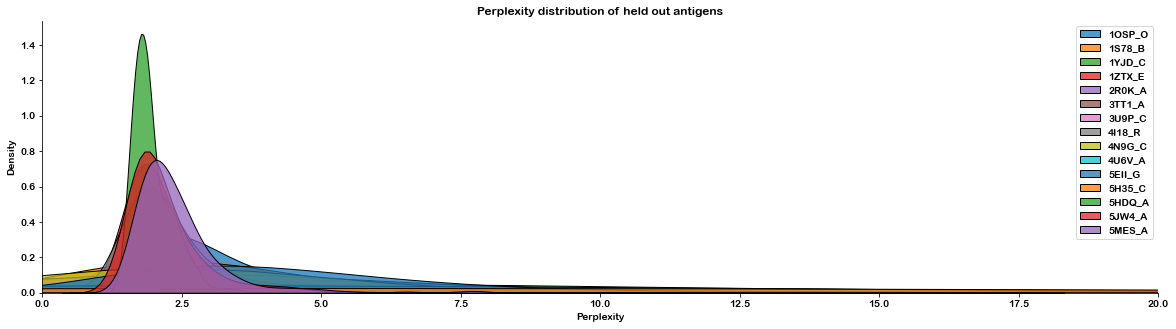

In [35]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_xlim(0,20)
for i in range(len(per_seq)):
    sns.kdeplot(per_seq[i], multiple='stack', label=a[i])
ax.legend()

ax.set_title("Perplexity distribution of held out antigens")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("Perplexity")
# ax.set_ylabel("Mean perplexity over tokens")
fig.savefig("../experiments_data/figures/Perplexity distribution of held out antigens.pdf", dpi=600)

In [37]:
# 2. generative testing
data = pickle.load(open("../absolute_antibody/paired_data/paired_abag_data.pkl", 'rb'))

In [44]:
# get all sequences 
all_antibody_seqs = [data[i]['antibody_data'] for i in a]
all_antigen_seqs = [data[i]['antigen_sequence'] for i in a]


In [64]:

all_antibody_heros = []
for id in a: 
    all_antibody_heros.append(list(pd.read_table("../absolute_antibody/CDRH3_superhero/" + id + "_supers.txt", skiprows=1)['CDR3']))

In [40]:
data['1ADQ_A'].keys()

dict_keys(['structure', 'antibody_data', 'antigen_sequence'])

In [ ]:
# generate test
nlls_all = []
nature_nlls_all = []
seqs_all = []
for i in range(15):
    antigen_seq = all_antigen_seqs[i]
    antigen_seq = ' '.join(list(antigen_seq))
    antigen_encode = pretrained_model(**tokenizer(antigen_seq,
                                                    return_tensors='pt')).last_hidden_state.squeeze(0)[1:-1, :].detach()
    s = time.time()
    generator = CDRGenerate(model=current_model,
                            antigen=antigen_encode)
    seqs, nlls = generator.generate(500, 60, p=0.95, method='top-p')
    print(f"Running time: {time.time() - s}s.")

    nature_nlls = []
    metrics = Metrics(model=current_model)
    for j in tqdm(range((len(all_antibody_heros[i])))):
        nature_nlls.append(metrics.negative_log_likelihood(all_antibody_heros[i][j][3: ], antigen=antigen_encode))
    nlls_all.append(nlls)
    seqs_all.append(seqs)
    nature_nlls_all.append(nature_nlls)


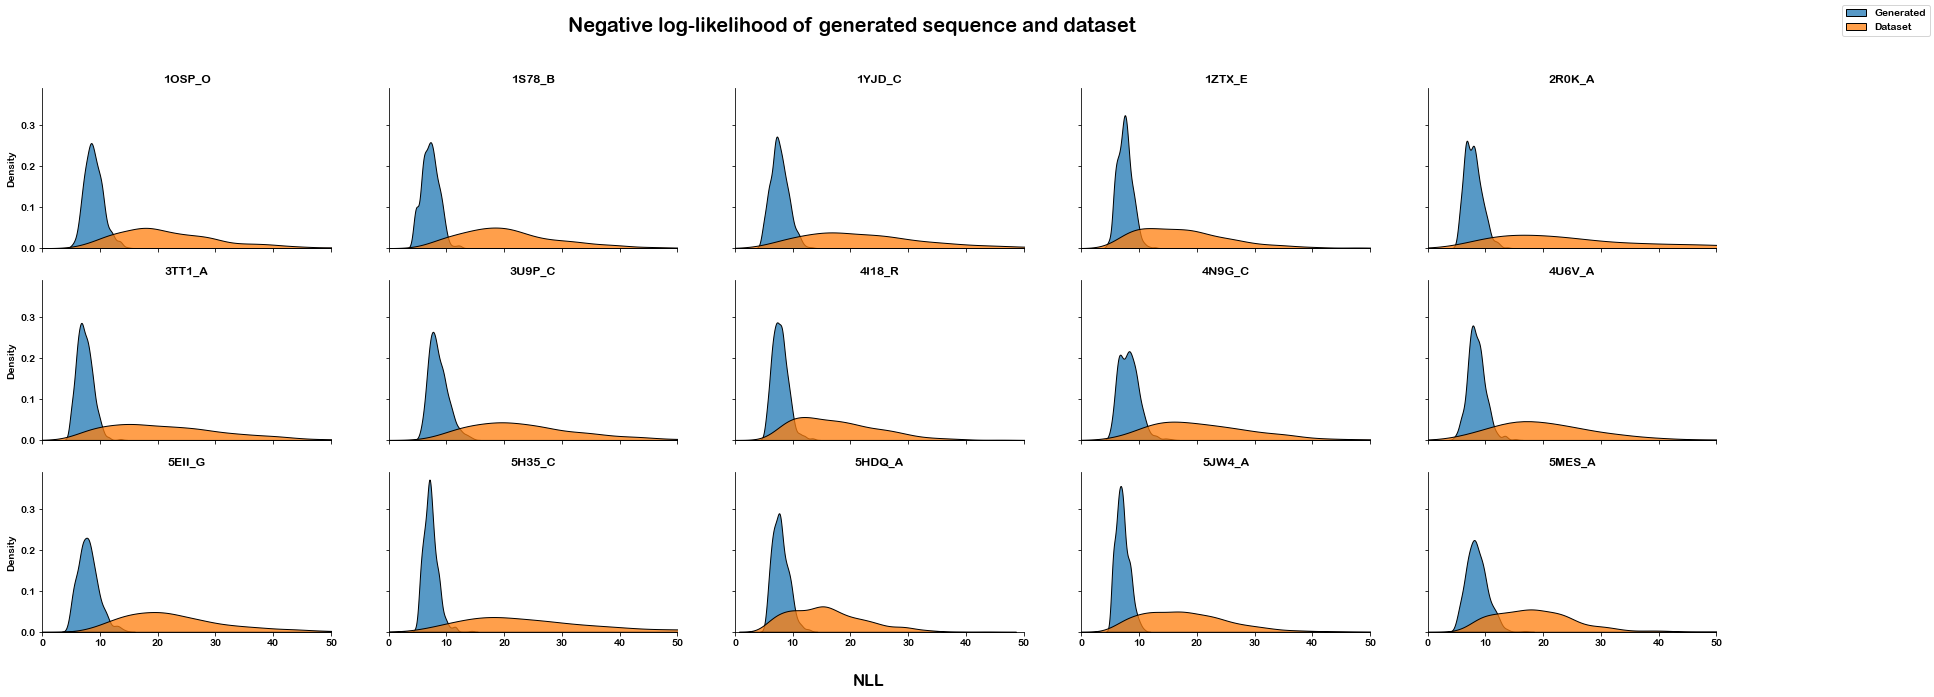

In [130]:
fig ,ax = plt.subplots(3,5, sharex=True, sharey=True, figsize=(30,10))
axs = ax.flatten()
for i in range(15):
    axs[i].set_xlim(0,50)
    sns.kdeplot(nlls_all[i], ax=axs[i], multiple='stack', label='Generated')
    sns.kdeplot(nature_nlls_all[i], ax=axs[i], multiple='stack', label='Dataset')
    axs[i].set_title(a[i])
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
handles, labels = axs[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.text(0.5, 0.05,'NLL', fontsize=16)
fig.suptitle("Negative log-likelihood of generated sequence and dataset",fontsize=20)
fig.savefig("Negative log-likelihood of generated sequence and dataset.pdf", dpi=600)
    

In [133]:
# ID test 1ADQ_A
adq_ag = data['1ADQ_A']['antigen_sequence']
adg_heros = list((pd.read_table("../absolute_antibody/CDRH3_superhero/" + '1ADQ_A' + "_supers.txt", skiprows=1)['CDR3']))

In [143]:
antigen_seq = ' '.join(list(adq_ag))
antigen_encode = pretrained_model(**tokenizer(antigen_seq,
                                                return_tensors='pt')).last_hidden_state.squeeze(0)[1:-1, :].detach()
s = time.time()
generator = CDRGenerate(model=current_model,
                        antigen=antigen_encode)
seqs, nlls = generator.generate(500, 60, p=0.95, method='top-p')
print(f"Running time: {time.time() - s}s.")

nature_nlls = []
metrics = Metrics(model=current_model)
for j in tqdm(range((len(adg_heros)))):
    nature_nlls.append(metrics.negative_log_likelihood(adg_heros[j], antigen=antigen_encode))

Running time: 193.65046095848083s.


100%|██████████| 710/710 [05:16<00:00,  2.25it/s]


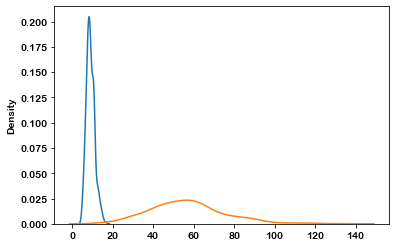

In [147]:
fig, ax = plt.subplots()
sns.kdeplot(nlls)
sns.kdeplot(nature_nlls)
fig.savefig("out.pdf")

In [154]:
# 3. GPCR
gpcr = 'MGAGVLVLGASEPGNLSSAAPLPDGAATAARLLVPASPPASLLPPASESPEPLSQQWTAGMGLLMALIVLLIVAGNVLVIVAIAKTPRLQTLTNLFIMSLASADLVMGLLVVPFGATIVVWGRWEYGSFFCELWTSVDVLCVTASIETLCVIALDRYLAITSPFRYQSLLTRARARGLVCTVWAISALVSFLPILMHWWRAESDEARRCYNDPKCCDFVTNRAYAIASSVVSFYVPLCIMAFVYLRVFREAQKQVKKIDSCERRFLGGPARPPSPSPSPVPAPAPPPGPPRPAAAAATAPLANGRAGKRRPSRLVALREQKALKTLGIIMGVFTLCWLPFFLANVVKAFHRELVPDRLFVFFNWLGYANSAFNPIIYCRSPDFRKAFQRLLCCARRAARRRHATHGDRPRASGCLARPGPPPSPGAASDDDDDDVVGATPPARLLEPWAGCNGGAAADSDSSLDEPCRPGFASESKV'



In [188]:
gpcr_heros = list(pd.read_csv("../experiments_data/gpcr_cdrh3.csv")['cdrh3'])
with open("gpcr.fa", 'w') as f:
    for i in gpcr_heros:
        f.write("> " + i + '\n')
        f.write(i + '\n')

In [186]:
antigen_seq = ' '.join(list(gpcr))
antigen_encode = pretrained_model(**tokenizer(antigen_seq,
                                                return_tensors='pt')).last_hidden_state.squeeze(0)[1:-1, :].detach()
s = time.time()
generator = CDRGenerate(model=current_model,
                        antigen=antigen_encode)
seqs, nlls = generator.generate(100, 60, p=0.95, method='top-p')
print(f"Running time: {time.time() - s}s.")

with open("gen_gpcr.fa", 'w') as f:
    for i in seqs:
        f.write("> gen" + i + '\n')
        f.write(i + '\n')



Running time: 38.30524230003357s.


In [159]:
nature_nlls = []
metrics = Metrics(model=current_model)
for j in tqdm(range((len(gpcr_heros)))):
    nature_nlls.append(metrics.negative_log_likelihood(gpcr_heros[j] + 'W', antigen=antigen_encode))

100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


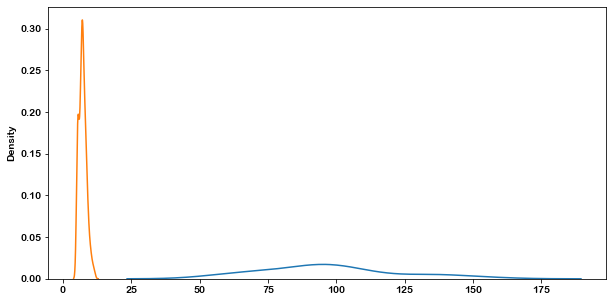

In [164]:
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(nature_nlls)
sns.kdeplot(nlls)
fig.savefig("../experiments_data/figures/gpcr nll distribution.pdf")

In [169]:
# seq logo of 1ADQ_A
with open("adg.fa", 'w') as f:
    for i in adg_heros:
        f.write("> " + i + '\n')
        f.write(i[3:-1] + '\n')


In [170]:
# seq logo of generated 1ADQ_A
antigen_seq = ' '.join(list(adq_ag))
antigen_encode = pretrained_model(**tokenizer(antigen_seq,
                                                return_tensors='pt')).last_hidden_state.squeeze(0)[1:-1, :].detach()
s = time.time()
generator = CDRGenerate(model=current_model,
                        antigen=antigen_encode)
seqs, nlls = generator.generate(500, 60, p=0.95, method='top-p')
print(f"Running time: {time.time() - s}s.")

Running time: 158.53613567352295s.


In [171]:
with open("generated_adg.fa", 'w') as f:
    for i in seqs:
        f.write("> " + i + '\n')
        f.write(i[3:-1] + '\n')

In [173]:
data.keys()

dict_keys(['1ADQ_A', '1FBI_X', '1FNS_A', '1FSK_A', '1H0D_C', '1JPS_T', '1MHP_A', '1NCA_N', '1NCB_N', '1NSN_S', '1OAZ_A', '1OB1_C', '1OSP_O', '1PKQ_J', '1RJL_C', '1S78_B', '1TQB_A', '1WEJ_F', '1YJD_C', '1ZTX_E', '2B2X_A', '2DD8_S', '2HFG_R', '2IH3_C', '2JEL_P', '2Q8A_A', '2R0K_A', '2R29_A', '2R4R_A', '2R56_A', '2UZI_R', '2VXQ_A', '2VXT_I', '2W9E_A', '2WUC_I', '2XQB_A', '2XWT_C', '2YC1_C', '2YPV_A', '2ZCH_P', '3B9K_A', '3BGF_S', '3BN9_A', '3EFD_K', '3G04_C', '3GI9_C', '3HI6_A', '3JBQ_B', '3KJ4_A', '3KR3_D', '3KS0_J', '3L5W_I', '3L5X_A', '3L95_X', '3MJ9_A', '3NCY_A', '3NFP_I', '3NH7_A', '3NPS_A', '3Q3G_E', '3R08_E', '3R1G_B', '3RAJ_A', '3RKD_A', '3RVV_A', '3SKJ_E', '3SO3_A', '3SQO_A', '3TT1_A', '3U9P_C', '3UBX_A', '3V6O_A', '3VG9_A', '3VRL_C', '3WD5_A', '4AEI_A', '4CAD_C', '4DKE_A', '4H88_A', '4HC1_B', '4Hj0_A', '4HJ0_B', '4I18_R', '4I77_Z', '4IJ3_A', '4K24_A', '4K3J_A', '4K9E_C', '4KI5_M', '4KXZ_A', '4KXZ_B', '4KXZ_E', '4LQF_A', '4LU5_B', '4M7L_T', '4MXV_B', '4N9G_C', '4NP4_A', '4OII_A',

In [177]:
# sequence logos!
for name in data.keys():
    logo_heros = list((pd.read_table("../absolute_antibody/CDRH3_superhero/" + name + "_supers.txt", skiprows=1)['CDR3']))
    with open("../experiments_data/seq_logo_files/" + name + ".fa", 'w') as f:
        for i in range(len(logo_heros)):
            f.write("> " + str(i) + '\n')
            f.write(logo_heros[i][3:-1] + '\n')

In [182]:
adq_ag = data['1ZTX_E']['antigen_sequence']
antigen_seq = ' '.join(list(adq_ag))
antigen_encode = pretrained_model(**tokenizer(antigen_seq,
                                                return_tensors='pt')).last_hidden_state.squeeze(0)[1:-1, :].detach()
s = time.time()
generator = CDRGenerate(model=current_model,
                        antigen=antigen_encode)
seqs, nlls = generator.generate(500, 60, p=0.95, method='top-p')
print(f"Running time: {time.time() - s}s.")

with open("1ztx_e_generated_adg.fa", 'w') as f:
    for i in seqs:
        f.write("> " + i + '\n')
        f.write(i + '\n')

Running time: 116.81408643722534s.


In [179]:
data.keys()

dict_keys(['1ADQ_A', '1FBI_X', '1FNS_A', '1FSK_A', '1H0D_C', '1JPS_T', '1MHP_A', '1NCA_N', '1NCB_N', '1NSN_S', '1OAZ_A', '1OB1_C', '1OSP_O', '1PKQ_J', '1RJL_C', '1S78_B', '1TQB_A', '1WEJ_F', '1YJD_C', '1ZTX_E', '2B2X_A', '2DD8_S', '2HFG_R', '2IH3_C', '2JEL_P', '2Q8A_A', '2R0K_A', '2R29_A', '2R4R_A', '2R56_A', '2UZI_R', '2VXQ_A', '2VXT_I', '2W9E_A', '2WUC_I', '2XQB_A', '2XWT_C', '2YC1_C', '2YPV_A', '2ZCH_P', '3B9K_A', '3BGF_S', '3BN9_A', '3EFD_K', '3G04_C', '3GI9_C', '3HI6_A', '3JBQ_B', '3KJ4_A', '3KR3_D', '3KS0_J', '3L5W_I', '3L5X_A', '3L95_X', '3MJ9_A', '3NCY_A', '3NFP_I', '3NH7_A', '3NPS_A', '3Q3G_E', '3R08_E', '3R1G_B', '3RAJ_A', '3RKD_A', '3RVV_A', '3SKJ_E', '3SO3_A', '3SQO_A', '3TT1_A', '3U9P_C', '3UBX_A', '3V6O_A', '3VG9_A', '3VRL_C', '3WD5_A', '4AEI_A', '4CAD_C', '4DKE_A', '4H88_A', '4HC1_B', '4Hj0_A', '4HJ0_B', '4I18_R', '4I77_Z', '4IJ3_A', '4K24_A', '4K3J_A', '4K9E_C', '4KI5_M', '4KXZ_A', '4KXZ_B', '4KXZ_E', '4LQF_A', '4LU5_B', '4M7L_T', '4MXV_B', '4N9G_C', '4NP4_A', '4OII_A',

In [181]:
with open("5fb8_c_generated_adg.fa", 'w') as f:
    for i in seqs:
        f.write("> " + i + '\n')
        f.write(i + '\n')